In [31]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import math
import matplotlib.pyplot as plt
import init_objects
from functions.helpers import organise_data, hypothetical_series, get_specific_bootstraps_moments, confidence_interval, quadratic_loss_function
from functions.inequality import gini
from functions.stylizedfacts import autocorrelation_returns
from model import *
import statsmodels.api as sm
from matplotlib import style
import scipy.stats as stats
from SALib.sample import latin
from hurst import compute_Hc

In [2]:
style.use('seaborn-ticks')

# Asset price volatility and wealth inequality

This notebook contains the following steps:

1. Parameter calibration and estimation
2. Model dynamics
3. Experiment

## 1 Parameter calibration and estimation

### 1.1 Collect data

In [3]:
shiller_data = pd.read_excel('http://www.econ.yale.edu/~shiller/data/ie_data.xls', header=7)[:-3]
p = pd.Series(np.array(shiller_data.iloc[1174:-1]['Price'])) #starting in 1952  was 1224
price_div = pd.Series(np.array(shiller_data.iloc[1174:-1]['CAPE']))
p_returns = pd.Series(np.array(shiller_data.iloc[1174:]['Price'])).pct_change()[1:]
pd_returns = pd.Series(np.array(shiller_data.iloc[1174:]['CAPE'])).pct_change()[1:]

### 1.2 calibration

First, I set two parameters for computational efficiency

Then, I calibrate parameters using data and literature. 

In [4]:
params = {"trader_sample_size": 10, # selected for comp efficiency
          "n_traders": 400, # selected for comp efficiency
          "init_stocks": int((21780000000 / 267.33) / float(1000000)), # market valuation of Vanguard S&P 500 / share price 
          "ticks": len(p), # lenght of reference data
          "fundamental_value": p.mean(), # average value of reference data, assuming efficient markets
          "base_risk_aversion": 0.7, # estimate from Kim & Lee (2012) = 0.7
          'spread_max': 0.004087, # estimate from Riordan & Storkenmaier (2012)
          "horizon": int(len(p) * 0.35), # estimate based on average churn ratio found by Cella, Ellul and Giannetti (2013)
          # estimated parameters
          "std_noise": 0.01, 
          "w_random": 1.0, 
          "strat_share_chartists": 0.0,
          # fixed / not modelled parameters
          "fundamentalist_horizon_multiplier": 1.0
         }

In [5]:
params

{'trader_sample_size': 10,
 'n_traders': 400,
 'init_stocks': 81,
 'ticks': 611,
 'fundamental_value': 1129.8774292002786,
 'base_risk_aversion': 0.7,
 'spread_max': 0.004087,
 'horizon': 213,
 'std_noise': 0.01,
 'w_random': 1.0,
 'strat_share_chartists': 0.0,
 'fundamentalist_horizon_multiplier': 1.0}

Finally, there are seven parameters left which are difficult to calibrate. Therefore, I estimate these values using the method of simulated moments. The starting point of this method is finding appropriate moments which the model should be able to replicate. I note that there should be more moments than parameters. Since 3 parameters need to be estimated, 4 moments are needed. Since this is a highly stylized model, I am only interested in the model replicating some basic moments of the price return series. The moments are the autocorrelation, autocorrelation of absolute returns, kurtosis of returns and hurst of the price. 

First, I calculate these moments for the empirical data. 

In [6]:
emp_moments = np.array([
    autocorrelation_returns(p_returns, 25),
    autocorrelation_returns(p_returns.abs(), 25),
    p_returns.kurtosis(),
    compute_Hc(p, kind='price', simplified=True)[0]
    ])
emp_moments
np.save('emp_moments', emp_moments)

To account for the fact that some of these moments might correlate over different Monte Carlo Simulations, the MSM seeks to obtain a variance covariance matrix of the moments. Since there is only one empirical reality, I use a bootstrap procedure to create a covariance matrix of empirical moments. For this, I use a block bootstrap procedure.

In [7]:
BLOCK_SIZE = 25
BOOTSTRAPS = 100

In [8]:
p_data_blocks = []
price_data_blocks = []
for x in range(0, len(p_returns[:-3]), BLOCK_SIZE):
    p_data_blocks.append(p_returns[x:x + BLOCK_SIZE])
    price_data_blocks.append(p[x:x + BLOCK_SIZE])

In [9]:
bootstrapped_p_returns = []
bootstrapped_prices = []
for i in range(BOOTSTRAPS):
    sim_data_p = [random.choice(p_data_blocks) for _ in p_data_blocks]
    sim_data2_p = [j for i in sim_data_p for j in i]
    bootstrapped_p_returns.append(sim_data2_p)
    
    sim_data_price = [random.choice(price_data_blocks) for _ in price_data_blocks]
    sim_data2_price = [j for i in sim_data_price for j in i]
    bootstrapped_prices.append(sim_data2_price)
    

In [10]:
rets_autocor = []
rets_abs_autocors = []
kurts = []
hursts = []

for rets, prices in list(zip(bootstrapped_p_returns, bootstrapped_prices)):
    rets_autocor.append(autocorrelation_returns(rets, 25))
    rets_abs_autocors.append(autocorrelation_returns(np.abs(rets), 25))
    kurts.append(pd.Series(rets).kurtosis())
    hursts.append(compute_Hc(prices, kind='price', simplified=True)[0])

In [11]:
all_bootstrapped_moments = [
                            rets_autocor,
                            rets_abs_autocors,
                            kurts,
                            hursts
                           ]

In [12]:
av_moments = [np.nanmean(x) for x in all_bootstrapped_moments]
moments_b = [get_specific_bootstraps_moments(all_bootstrapped_moments, n) for n in range(len(bootstrapped_p_returns))]

Here, I follow [Franke & Westerhoff 2016](https://link.springer.com/article/10.1007/s11403-014-0140-6#Sec8) in that I use the inverse of the bootstrap estimate of the moment covariance matrix as my weights.

In [13]:
W_hat = 1.0 / len(bootstrapped_p_returns) * sum([np.dot(np.array([(mb - av_moments)]).transpose(), np.array([(mb - av_moments)])) for mb in moments_b])
W = np.linalg.inv(W_hat)
np.save('distr_weighting_matrix', W)

I establish confidence intervals for the moments

In [14]:
confidence_intervals = [confidence_interval(m, emp) for m, emp in zip(all_bootstrapped_moments, emp_moments)]

In [15]:
j_values = []
for b in moments_b:
    j_values.append(quadratic_loss_function(b, emp_moments, W))

In [16]:
scores = [0 for x in moments_b[0]]
for bootstr in range(len(moments_b)):
    for idx, moment in enumerate(moments_b[bootstr]):
        if moment > confidence_intervals[idx][0] and moment < confidence_intervals[idx][1]:
            scores[idx] += 1
MCR_bootstrapped_moments = np.array(scores) / (np.ones(len(scores)) * len(moments_b))

To start the estimation procedure, I first sample the parameter space using Latin Hypercube sampling

In [17]:
population_size = 10

In [18]:
problem = {
  'num_vars': 3,
  'names': ['std_noise', "w_random", "strat_share_chartists"],
  'bounds': [[0.03, 0.09], [0.02, 0.15], [0.02, 0.7]]
}

In [19]:
latin_hyper_cube = latin.sample(problem=problem, N=population_size)
latin_hyper_cube = latin_hyper_cube.tolist()
with open('hypercube.txt', 'w') as f:
    json.dump(latin_hyper_cube, f)
initial_params = latin_hyper_cube[0]
initial_params

[0.06571162660759647, 0.10946214607195602, 0.11809545865288254]

I perform the estimation excercise in a different Python file using multi-processing. I download the resulting paramters below.

In [20]:
with open('estimated_params.json', 'r') as f:
    est_params = json.loads(f.read())

In [21]:
est_params

[0.04033319833897153, 0.11224867721546046, 0.22444217807262745]

In [22]:
for i, name in enumerate(problem['names']):
    params[name] = est_params[i]

Something prevents the chartists from gaining momentum. It is not risk aversion, init stocks.

Increasing the amount of traders though... might be important

In [41]:
params['ticks'] = 1200
params['n_traders'] = 1000
params['strat_share_chartists'] = 0.90

In [24]:
params

{'trader_sample_size': 10,
 'n_traders': 1000,
 'init_stocks': 81,
 'ticks': 1200,
 'fundamental_value': 1129.8774292002786,
 'base_risk_aversion': 0.7,
 'spread_max': 0.004087,
 'horizon': 213,
 'std_noise': 0.04033319833897153,
 'w_random': 0.11224867721546046,
 'strat_share_chartists': 0.22444217807262745,
 'fundamentalist_horizon_multiplier': 1.0}

In [25]:
#params['n_traders'] = 100

In [26]:
#params['std_noise'] = 0.09

In [27]:
#params['trader_sample_size'] = 19

In [28]:
#params["fundamentalist_horizon_multiplier"] = 4.0

# Volatility inequality model

In [42]:
NRUNS = 2

In [43]:
trdrs = []
orbs = []
for seed in range(NRUNS):
    traders, orderbook = init_objects.init_objects(params, seed)
    traders, orderbook = exuberance_inequality_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
last mid-price was:  1398.9279780844822
Start of simulation  1
last mid-price was:  1619.006328717457


In [44]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(orbs, burn_in_period=0)

In [45]:
mc_volatility.mean().mean()

0.0040273453782319465

In [46]:
trdrs[0][1].var.weight_chartist

[0.81]

In [47]:
series_length = []
for col in mc_prices:
    try:
        series_length.append(mc_prices[mc_prices[col].isna()].index[0])
    except:
        series_length.append(len(mc_prices))

In [48]:
lower_c_price = []
upper_c_price = []
for row in range(min(series_length)-2):
    price_range = mc_prices.iloc[row]# / mc_fundamentals.iloc[row]
    lower, upper = confidence_interval(price_range, np.mean(price_range))
    lower_c_price.append(max(lower, 0.0))
    upper_c_price.append(upper)

Identify individual wealth changes

In [49]:
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []

real_ginis_ot = []
real_palmas_ot = []

profits = []
real_profits = []
market_returns = []

# determine the start and end wealth
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))
    real_profits.append(np.array(wealth_end) - np.array(wealth_start))
    market_returns.append([(orbs[seed].tick_close_price[-1] - orbs[seed].tick_close_price[0]) / orbs[seed].tick_close_price[0] for x in range(len(wealth_start))])

    wealth_gini_over_time = []
    palma_over_time = []
    
    real_wealth_gini_over_time = []
    real_palma_over_time = []
    for t in range(min(series_length) - 1):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs[seed].tick_close_price[t])
        real_wealth = np.array([x.var.real_wealth[t] for x in traders])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)
        
        real_share_top_10 = sum(np.sort(real_wealth)[int(len(real_wealth) * 0.9):]) / sum(real_wealth)
        real_share_bottom_40 = sum(np.sort(real_wealth)[:int(len(real_wealth) * 0.4)]) / sum(real_wealth)
        real_palma_over_time.append(real_share_top_10 / real_share_bottom_40)

        wealth_gini_over_time.append(gini(wealth))
        real_wealth_gini_over_time.append(gini(real_wealth))

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))
    ginis_ot.append(wealth_gini_over_time)
    palmas_ot.append(palma_over_time)
    real_ginis_ot.append(real_wealth_gini_over_time)
    real_palmas_ot.append(real_palma_over_time)

In [50]:
av_gini_ot = []
low_gini_ot = []
up_gini_ot = []

av_palma_ot = []
low_palma_ot = []
up_palma_ot = []

av_real_gini_ot = []
low_real_gini_ot = []
up_real_gini_ot = []

av_real_palma_ot = []
low_real_palma_ot = []
up_real_palma_ot = []

for t in range(min(series_length)-1):
    t_gini = [g[t] for g in ginis_ot]
    av_gini_ot.append(np.mean(t_gini))
    low, up = confidence_interval(t_gini, np.mean(t_gini))
    low_gini_ot.append(low)
    up_gini_ot.append(up)

    real_t_gini = [gr[t] for gr in real_ginis_ot]
    av_real_gini_ot.append(np.mean(real_t_gini))
    low, up = confidence_interval(real_t_gini, np.mean(real_t_gini))
    low_real_gini_ot.append(low)
    up_real_gini_ot.append(up)

    real_t_palma = [pr[t] for pr in real_palmas_ot]
    av_real_palma_ot.append(np.mean(real_t_palma))
    low, up = confidence_interval(real_t_palma, np.mean(real_t_palma))
    low_real_palma_ot.append(low)
    up_real_palma_ot.append(up)
    
    t_palma = [p[t] for p in palmas_ot]
    av_palma_ot.append(np.mean(t_palma))
    low, up = confidence_interval(t_palma, np.mean(t_palma))
    low_palma_ot.append(low)
    up_palma_ot.append(up)

# Does the noise trader model tend towards an unequal steady state?

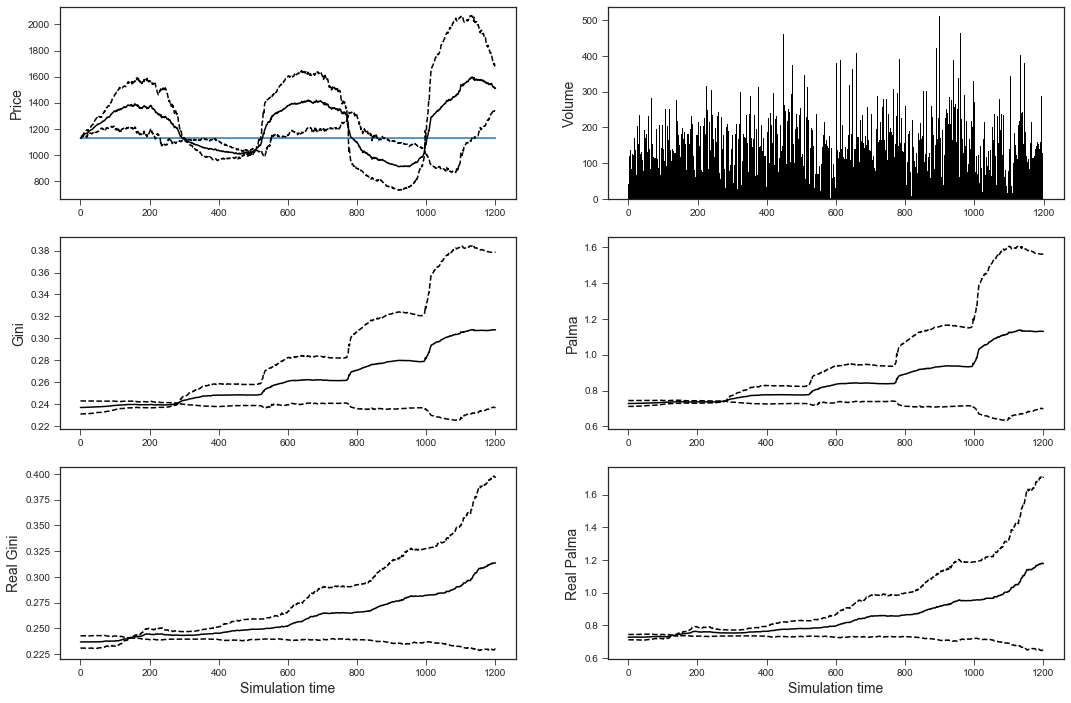

In [112]:
fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(18,12))

ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), label='Fundamental')
#ax1.plot(mc_prices.index, (mc_prices.mean(axis=1) / mc_fundamentals.mean(axis=1))[:], label='Market')
ax1.plot(mc_prices.iloc[:min(series_length)-1].index, mc_prices.iloc[:min(series_length)-1].mean(axis=1), 'k', label='Market')
ax1.plot(mc_prices.iloc[:min(series_length)-1].index[:-1], lower_c_price, 'k--')
ax1.plot(mc_prices.iloc[:min(series_length)-1].index[:-1], upper_c_price, 'k--')

ax1.set_ylabel('Price', fontsize='14')

ax2.bar(mc_volume.iloc[:min(series_length)-1].index, mc_volume.iloc[:min(series_length)-1].mean(axis=1), width=1.0, color='black')
ax2.set_ylabel('Volume', fontsize='14')

ax3.plot(range(len(av_gini_ot[:])), av_gini_ot[:], 'k')
ax3.plot(range(len(low_gini_ot[:])), low_gini_ot[:], 'k--')
ax3.plot(range(len(up_gini_ot[:])), up_gini_ot[:], 'k--')
ax3.set_ylabel('Gini', fontsize='14')

ax4.plot(range(len(av_gini_ot[:])), av_palma_ot[:], 'k')
ax4.plot(range(len(low_gini_ot[:])), low_palma_ot[:], 'k--')
ax4.plot(range(len(up_gini_ot[:])), up_palma_ot[:], 'k--')
ax4.set_ylabel('Palma', fontsize='14')

ax5.plot(range(len(av_real_gini_ot[:])), av_real_gini_ot[:], 'k')
ax5.plot(range(len(low_real_gini_ot[:])), low_real_gini_ot[:], 'k--')
ax5.plot(range(len(up_real_gini_ot[:])), up_real_gini_ot[:], 'k--')
ax5.set_ylabel('Real Gini', fontsize='14')

ax6.plot(range(len(av_real_gini_ot[:])), av_real_palma_ot[:], 'k')
ax6.plot(range(len(low_real_gini_ot[:])), low_real_palma_ot[:], 'k--')
ax6.plot(range(len(up_real_gini_ot[:])), up_real_palma_ot[:], 'k--')
ax6.set_ylabel('Real Palma', fontsize='14')


for ax in (ax5, ax6):
    ax.set_xlabel('Simulation time', fontsize='14')
    
fig.savefig('baseline_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# Do individual traders see their wealth diminish below a lower bound

In [53]:
# lower_bound = price
perc_traders_lower_bound_ot = []
for seed, traders in enumerate(trdrs):
    perc_traders_lower_bound = []
    for t in range(min(series_length) - 1):
        #print(t)
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs[seed].tick_close_price[t])

        sorted_wealth = np.sort(wealth)
        cumsum_wealth = pd.Series(np.cumsum(sorted_wealth) / sum(wealth))
        perc_traders_bottom20 = cumsum_wealth[cumsum_wealth > 0.1].index[0] / float(len(wealth))
        perc_traders_lower_bound.append(perc_traders_bottom20)
    
    perc_traders_lower_bound_ot.append(perc_traders_lower_bound)

In [54]:
av_perc_tr_lb = []
low_perc_tr_lb = []
high_perc_tr_lb = []

for t in range(min(series_length)-1):
    t_ptlb = [g[t] for g in perc_traders_lower_bound_ot]
    av_perc_tr_lb.append(np.mean(t_ptlb))
    low, up = confidence_interval(t_ptlb, np.mean(t_ptlb))
    low_perc_tr_lb.append(low)
    high_perc_tr_lb.append(up)

Text(0.5, 0, 'Simulation time')

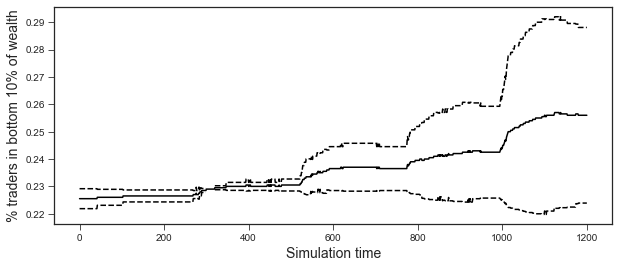

In [55]:
# what I want to measure: people are getting too poor to trade 
fig, ax = plt.subplots(1, 1, figsize=(10,4))

ax.plot(range(len(av_perc_tr_lb[:])), av_perc_tr_lb[:], 'k')
ax.plot(range(len(low_perc_tr_lb[:])), low_perc_tr_lb[:], 'k--')
ax.plot(range(len(high_perc_tr_lb[:])), high_perc_tr_lb[:], 'k--')
ax.set_ylabel('% traders in bottom 10% of wealth', fontsize='14')


ax.set_xlabel('Simulation time', fontsize='14')

#fig.savefig('rise_of_poverty.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# Experiment 

In [94]:
exuberance = [x / 100.0 for x in range(0, 100, 5)]
exuberance = exuberance[10:19]

In [95]:
exuberance

[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

In [99]:
NRUNS = 5

In [100]:
params['ticks'] = 1000

In [101]:
experiments = len(exuberance)

In [102]:
trdrs = []
orbs = []

for exp in range(experiments):
    params['strat_share_chartists'] = exuberance[exp]
    for seed in range(NRUNS): 
        traders, orderbook = init_objects.init_objects(params, seed)
        traders, orderbook = exuberance_inequality_model(traders, orderbook, params, seed)
        trdrs.append(traders)
        orbs.append(orderbook)

Start of simulation  0
last mid-price was:  1133.7293578987142
Start of simulation  1
last mid-price was:  1192.5419857676466
Start of simulation  2
last mid-price was:  1134.1137433665162
Start of simulation  3
last mid-price was:  1146.7894392838416
Start of simulation  4
last mid-price was:  1167.9993973588166
Start of simulation  0
last mid-price was:  1132.3769646437668
Start of simulation  1
last mid-price was:  1189.8714202952349
Start of simulation  2
last mid-price was:  1145.082379484631
Start of simulation  3
last mid-price was:  1132.6490550777519
Start of simulation  4
last mid-price was:  1141.2682705536085
Start of simulation  0
last mid-price was:  1149.0768133115123
Start of simulation  1
last mid-price was:  1201.894130204069
Start of simulation  2
last mid-price was:  1097.6484295700036
Start of simulation  3
last mid-price was:  1172.998558512722
Start of simulation  4
last mid-price was:  1140.4308186951303
Start of simulation  0
last mid-price was:  1146.568318583

In [103]:
full_exuberance = []
for exp in range(experiments):
    for seed in range(NRUNS):
        full_exuberance.append(exuberance[exp])

In [104]:
ginis = []
palmas = []
real_ginis = []
real_palmas = []

for idx, traders in enumerate(trdrs):
    money = np.array([x.var.money[-1] for x in trdrs[idx]])
    stocks = np.array([x.var.stocks[-1] for x in trdrs[idx]])
    wealth = money + (stocks * orbs[idx].tick_close_price[-1])
    real_wealth = np.array([x.var.real_wealth[-1] for x in traders])
    
    share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
    share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
    palmas.append(share_top_10 / share_bottom_40)
    
    ginis.append(gini(wealth))
    
    share_top_10 = sum(np.sort(real_wealth)[int(len(real_wealth) * 0.9):]) / sum(real_wealth)
    share_bottom_40 = sum(np.sort(real_wealth)[:int(len(real_wealth) * 0.4)]) / sum(real_wealth)
    real_palmas.append(share_top_10 / share_bottom_40)
    
    real_ginis.append(gini(real_wealth))

In [105]:
# calc redistribution, profits ... abs 
profits = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))

In [106]:
# collect data on volatility
mc_prices_exp, mc_returns_exp, mc_autocorr_returns_exp, mc_autocorr_abs_returns_exp, mc_volatility_exp, mc_volume_exp, mc_fundamentals_exp = organise_data(orbs, burn_in_period=0)

In [107]:
av_stdev_prices_exp = list(mc_prices_exp.std(axis=0))

In [108]:
av_abs_profits = list(pd.DataFrame(profits).transpose().abs().mean(axis=0))

In [109]:
# split the data in parts of NRUNS
gini_averages = []
gini_conf_interval_uppers = []
gini_conf_intervals_lowers = []

palma_averages = []
palma_conf_interval_uppers = []
palma_conf_intervals_lowers = []

real_gini_averages = []
real_gini_conf_interval_uppers = []
real_gini_conf_intervals_lowers = []

real_palma_averages = []
real_palma_conf_interval_uppers = []
real_palma_conf_intervals_lowers = []

pr_averages = []
pr_conf_interval_uppers = []
pr_conf_intervals_lowers = []

vol_averages = []
vol_conf_interval_uppers = []
vol_conf_intervals_lowers = []

for x in range(experiments):
    y = x*NRUNS
    
    g = ginis[y:y+NRUNS]
    gini_averages.append(np.mean(g))
    sample_stdev = np.std(g)
    sigma = sample_stdev/math.sqrt(len(g))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(g), scale = sigma) 
    gini_conf_interval_uppers.append(min(upper, 1.0))
    gini_conf_intervals_lowers.append(lower)
    
    p = palmas[y:y+NRUNS]
    palma_averages.append(np.mean(p))
    sample_stdev = np.std(p)
    sigma = sample_stdev/math.sqrt(len(p))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p), scale = sigma) 
    palma_conf_interval_uppers.append(upper)
    palma_conf_intervals_lowers.append(max(lower, 0))
    
    rg = real_ginis[y:y+NRUNS] #TODO fix from here
    real_gini_averages.append(np.mean(rg))
    sample_stdev = np.std(rg)
    sigma = sample_stdev/math.sqrt(len(rg))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(rg), scale = sigma) 
    real_gini_conf_interval_uppers.append(min(upper, 1.0))
    real_gini_conf_intervals_lowers.append(lower)
    
    rp = real_palmas[y:y+NRUNS]
    real_palma_averages.append(np.mean(rp))
    sample_stdev = np.std(rp)
    sigma = sample_stdev/math.sqrt(len(rp))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(rp), scale = sigma) 
    real_palma_conf_interval_uppers.append(upper)
    real_palma_conf_intervals_lowers.append(max(lower, 0))
    
    pr = av_abs_profits[y:y+NRUNS]
    pr_averages.append(np.mean(pr))
    sample_stdev = np.std(pr)
    sigma = sample_stdev/math.sqrt(len(pr))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(pr), scale = sigma) 
    pr_conf_interval_uppers.append(upper)
    pr_conf_intervals_lowers.append(max(lower, 0))
    
    v = av_stdev_prices_exp[y:y+NRUNS]
    vol_averages.append(np.mean(v))
    sample_stdev = np.std(v)
    sigma = sample_stdev/math.sqrt(len(v))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(v), scale = sigma) 
    vol_conf_interval_uppers.append(upper)
    vol_conf_intervals_lowers.append(max(lower, 0))

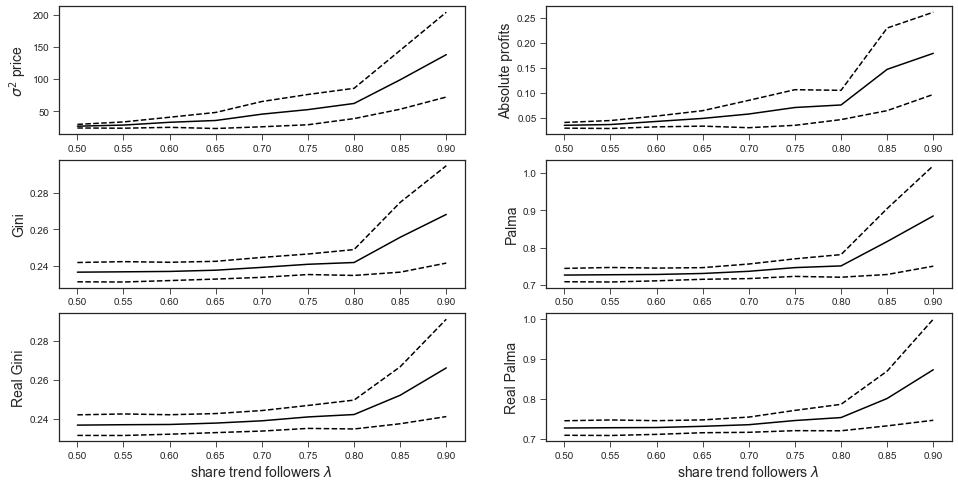

In [111]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=[16,8])

ax1.plot(exuberance, vol_averages, 'k')
ax1.plot(exuberance, vol_conf_interval_uppers, 'k--')
ax1.plot(exuberance, vol_conf_intervals_lowers, 'k--')

ax2.plot(exuberance, pr_averages, 'k')
ax2.plot(exuberance, pr_conf_interval_uppers, 'k--')
ax2.plot(exuberance, pr_conf_intervals_lowers, 'k--')

ax3.plot(exuberance, gini_averages, 'k')
ax3.plot(exuberance, gini_conf_interval_uppers, 'k--')
ax3.plot(exuberance, gini_conf_intervals_lowers, 'k--')

ax4.plot(exuberance, palma_averages, 'k')
ax4.plot(exuberance, palma_conf_interval_uppers, 'k--')
ax4.plot(exuberance, palma_conf_intervals_lowers, 'k--')

ax5.plot(exuberance, real_gini_averages, 'k')
ax5.plot(exuberance, real_gini_conf_interval_uppers, 'k--')
ax5.plot(exuberance, real_gini_conf_intervals_lowers, 'k--')

ax6.plot(exuberance, real_palma_averages, 'k')
ax6.plot(exuberance, real_palma_conf_interval_uppers, 'k--')
ax6.plot(exuberance, real_palma_conf_intervals_lowers, 'k--')

ax1.set_ylabel('$\sigma^2$ price', fontsize=14)
ax2.set_ylabel('Absolute profits', fontsize=14)
ax3.set_ylabel('Gini', fontsize=14)
ax4.set_ylabel('Palma', fontsize=14)
ax5.set_ylabel('Real Gini', fontsize=14)
ax6.set_ylabel('Real Palma', fontsize=14)


for ax in [ax5, ax6]:
    ax.set_xlabel('share trend followers $\lambda$', fontsize=14)

fig.savefig('exuberance_inequality.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# Experiment with init inequality

In [224]:
init_equality = [x / 100.0 for x in range(10, 100, 20)]
init_equality = init_equality[::-1]
print(init_equality)

[0.9, 0.7, 0.5, 0.3, 0.1]


In [225]:
stdev_fun = [x / 100.0 for x in range(10, 100, 20)]
#stdev_fun[0] = 0.0001
stdev_fun

[0.1, 0.3, 0.5, 0.7, 0.9]

In [121]:
#params['std_noise'] = 0.4

In [226]:
NRUNS = 5

In [244]:
av_init_gini = []
av_init_palma = []
av_gini_diff = []
av_palma_diff = []
stdev_noise = []

#trdrs = []
#orbs = []
for std_exp in range(len(stdev_fun)):
    params['std_noise'] = stdev_fun[std_exp]
    for exp in range(len(init_equality)):
        init_gini = []
        gini_diffs = []
        init_palma = []
        palma_diffs = []
        
        equality = init_equality[exp]
        for seed in range(NRUNS): 
            traders, orderbook = init_objects_unequal(params, seed, equality)
            traders, orderbook = volatility_inequality_model2(traders, orderbook, params, seed)
            #trdrs.append(traders)
            #orbs.append(orderbook)
            
            money_start = np.array([x.var.money[0] for x in traders])
            stocks_start = np.array([x.var.stocks[0] for x in traders])
            wealth_start = money_start + (stocks_start * orbs[idx].tick_close_price[0])
            
            share_top_10 = sum(np.sort(wealth_start)[int(len(wealth_start) * 0.9):]) / sum(wealth_start)
            share_bottom_40 = sum(np.sort(wealth_start)[:int(len(wealth_start) * 0.4)]) / sum(wealth_start)
        
            init_palma.append(share_top_10 / share_bottom_40)
            init_gini.append(gini(wealth_start))

            money_end = np.array([x.var.money[-1] for x in traders])
            stocks_end = np.array([x.var.stocks[-1] for x in traders])
            wealth_end = money_end + (stocks_end * orbs[idx].tick_close_price[-1])
            
            end_share_top_10 = sum(np.sort(wealth_end)[int(len(wealth_end) * 0.9):]) / sum(wealth_end)
            end_share_bottom_40 = sum(np.sort(wealth_end)[:int(len(wealth_end) * 0.4)]) / sum(wealth_end)
            
            palma_diffs.append((end_share_top_10 / end_share_bottom_40 - share_top_10 / share_bottom_40) / share_top_10 / share_bottom_40)
            gini_diffs.append(gini(wealth_end) - gini(wealth_start))
        
        av_init_palma.append(np.mean(init_palma))
        av_palma_diff.append(np.mean(palma_diffs))
        
        av_init_gini.append(np.mean(init_gini))
        av_gini_diff.append(np.mean(gini_diffs))
        
        stdev_noise.append(stdev_fun[std_exp])

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of si

In [254]:
gini_data = pd.DataFrame({'delta Gini': av_gini_diff, 'initial Gini': av_init_gini, '$\sigma^{\epsilon}$': stdev_noise}).round(2)

In [255]:
gini_data = gini_data.pivot("initial Gini", "$\sigma^{\epsilon}$", "delta Gini")

In [262]:
palma_data = pd.DataFrame({'delta Palma': av_palma_diff, 'initial Palma': av_init_palma, '$\sigma^{\epsilon}$': stdev_noise}).round(2)

In [263]:
palma_data

,delta Palma,initial Palma,$\sigma^{\epsilon}$
0,1.592600e+02,1.42,0.1
1,2.547500e+02,2.17,0.1
2,6.403900e+02,4.50,0.1
3,7.319220e+03,22.27,0.1
4,2.061020e+10,45689.49,0.1
5,2.296900e+02,1.42,0.3
6,3.630000e+02,2.17,0.3
7,8.881900e+02,4.50,0.3
8,9.668250e+03,22.27,0.3
9,2.130156e+10,45689.49,0.3


In [257]:
palma_data = palma_data[palma_data['delta Palma']<10000]

In [258]:
palma_data = palma_data.pivot("initial Palma", "$\sigma^{\epsilon}$", "delta Palma")

In [148]:
import seaborn as sns 
sns.set()

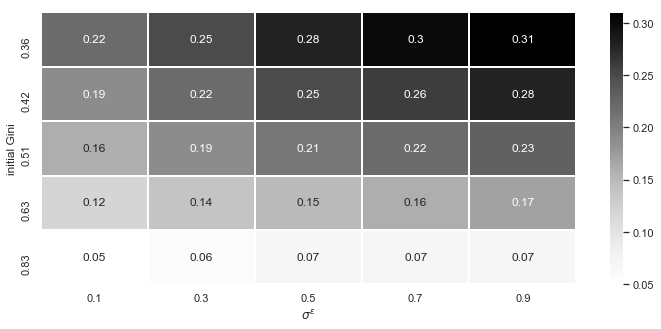

In [275]:
fig, ax1 = plt.subplots(1, 1, figsize=[12,5])

sns.heatmap(gini_data, cmap="Greys", ax=ax1, cbar=True, annot=True, linewidths=1, linecolor='white')
#sns.heatmap(palma_data, cmap="Greys", ax=ax2, cbar=True, annot=True)

fig.savefig('heatmap.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## Sensitivity analysis

In [276]:
# TODO 